## Notebook to test TherAPPy

The objective of this notebook is to show the functionality of TherAPPy

Note that the code is being developed and the structure and fucntionality of the code will change and improve. Get in touch with the developers if you feel that anything could be improved in particular. 

The code currently includes:

- The Dodson (1973) cooling age model for a range of thermochronometers
- The Ketcham (1999, 2007) apatite fission track annealing model
- The Meesters and Dunai (2002) apatite U-Th/He model, using the RDAAM model for the He diffusion coefficient (Flowers et al. 2007) 
- The easy%Ro and basin%Ro vitrinite reflectance models (Burnham & Sweeney 1989, Nielsen et al. 2015)

In [16]:
from importlib import reload
import itertools
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.colors
import astropy.units as u
from astropy.units import cds
import therappy.therappy_lib as trp

cds.enable() 

## Set up a temperature history

We will first set up a thermal history. There are a couple of predefined thermal histories in the module [therappy/default_thermal_histories.py](therappy/default_thermal_histories.py), including a standard thermal hsitory with cooling from 300 degrees to 10 degrees C in 100 million years, which we will use here.

If you would want to set up your own thermal history: The temperature history is stored in a python dictionary that contains two numpy arrays, one for time bp and one for temperature.
Note that the unit for time used in TherAPPy is years bp, and the unit for temperature is degrees C. TherAPPy uses the [astropy units](https://docs.astropy.org/en/stable/units/index.html) module to assign physical units to variables. 

Temperature history:
{'time': <Quantity [9.999e+07, 9.998e+07, 9.997e+07, ..., 2.000e+04, 1.000e+04,
           0.000e+00] yr>, 'temperature': <Quantity [300.       , 299.9709971, 299.9419942, ...,  10.0580058,
            10.0290029,  10.       ] deg_C>, 'thermal_history_name': 'simple'}


(104989500.0, -4999500.0)

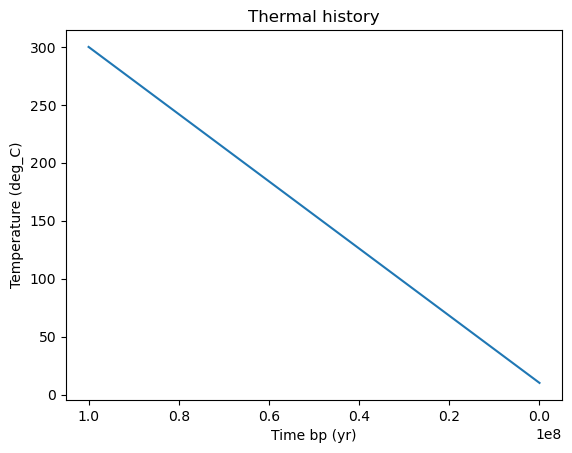

In [17]:
#time = np.arange(0, 100.0, 0.1)[::-1] * 1e6 * u.year
#temperature =  np.linspace(300, 10, len(time))  * u.deg_C
#tT = {"time": time, "temperature": temperature}

from therappy import default_thermal_histories 

tT = default_thermal_histories .thermal_history("simple")
print(f"Temperature history:\n{tT}")

fig, ax = pl.subplots(1, 1)
ax.set_title("Thermal history")
ax.plot(tT["time"], tT["temperature"])
ax.set_xlabel(f"Time bp ({tT['time'].unit})")
ax.set_ylabel(f"Temperature ({tT['temperature'].unit})")
ax.set_xlim(ax.get_xlim()[::-1])

# Model vitrinite reflectance

TherAPPy contains two methods to model vitrinite reflectance: easy%Ro and basin%Ro. Although technically speaking vitrinite reflectance is not a thermochronometer because it does not provide information on time, it is often a useful additional constraint on the maximum temperature a sample has reached over its burial history.

In [18]:
mygrain = trp.thermochron_object("vitrinite")
model_results_easyRo = mygrain.model_thermochron(tT, thermochronometer="reflectance", model="easyRo")
model_results_basinRo = mygrain.model_thermochron(tT, thermochronometer="reflectance", model="basinRo")

print(f"Modellled vitrinite reflectance Ro value using easy%Ro = {model_results_easyRo['modelled_Ro']:0.2f} and using basin%Ro = {model_results_basinRo['modelled_Ro']:0.2f}")

Modellled vitrinite reflectance Ro value using easy%Ro = 4.52 and using basin%Ro = 6.12


## Model closure ages using the Dodson model

We first model the closure ages following Dodson (1973) for the apatite and zircon (U-Th)/He and fission track thermochronometers, using parameters from Reiners and Brandon (2006, https://doi.org/10.1146/annurev.earth.34.031405.125202)

In [19]:
minerals = ["apatite", "apatite", "zircon", "zircon"]
thermochronometers = ["He", "FT", "He", "FT"]

grains = []
ages = []

# go through the thermochron systems
for mineral, thermochronometer in zip(minerals, thermochronometers):
    
    # create a new thermochron object for each mineral & thermochronometer combination
    mygrain = trp.thermochron_object(mineral) # geometry (size, shape), chemistry (eU / U / Th, Sm), zonation?
    
    # todo
    #mysample = sample(grain1, grain2)
    
    # model the thermochron age
    model_results = mygrain.model_thermochron(tT, thermochronometer=thermochronometer, model="Dodson") #dpar, 
    
    # store the ages
    ages.append(model_results["modelled_thermochron_age_bp"])
    
    # store the grain in a list
    grains.append(mygrain)
    
    print(f"modelled thermochron age for the system {mygrain.mineral} {thermochronometer} using the {mygrain.model} model: "
          f"{model_results['modelled_thermochron_age_bp']:0.2e}")

modelled thermochron age for the system apatite He using the Dodson model: 9.74e+06 yr
modelled thermochron age for the system apatite FT using the Dodson model: 2.46e+07 yr
modelled thermochron age for the system zircon He using the Dodson model: 4.54e+07 yr
modelled thermochron age for the system zircon FT using the Dodson model: 5.84e+07 yr


## Model AFT using the Ketcham (2007) model

Next we model the apatite fission track age using a implementation of the fission track annealing model described in Ketcham et al. (1999) and Ketcham (2007). The annealing resistance can be specified using the chlorine weight fraction or the Dpar parameter. We assing a chlorine weight fraction of 0.0 below.

In [20]:
# assign fission track annealing parameters
thermochron_parameters = {"kinetic_parameter": "Clwt", "Clwt": 0.0}

# set up a new grain
apatite_grain = trp.thermochron_object("apatite")

# model the apatite fission track age
model_results_AFT = apatite_grain.model_thermochron(tT, thermochronometer="FT", model="Ketcham2007", thermochron_parameters=thermochron_parameters)

modelled_AFT_age = model_results_AFT["modelled_thermochron_age"]

print(f"modelled apatite fission track age: {modelled_AFT_age :0.2e}")

modelled apatite fission track age: 2.87e+07 yr


# Model AHe using the Meesters and Dunai (2002) model

In [21]:
apatite_grain.U = 1.0 * cds.ppm
apatite_grain.Th = 1.0 * cds.ppm
apatite_grain.radius = 50e-6 * u.m

model_results_AHe = apatite_grain.model_thermochron(tT, thermochronometer="He", model="Meesters2002")#, diffusivity_model="Farley2000")
modelled_AHe_age = model_results_AHe["modelled_thermochron_age"]

print(f"modelled apatite (U-Th)/He age: {modelled_AHe_age :0.2e}")

radius = 5e-05
U = 1e-06
U = 1e-06
modelled apatite (U-Th)/He age: 1.02e+07 yr


# Show T history and modelled ages in a figure

Lets compare the closure ages with the modelled apatite fission track age:

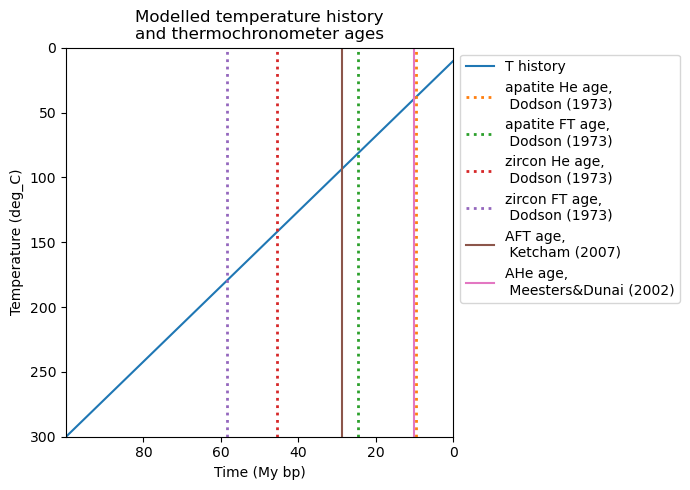

In [22]:
colors = list(matplotlib.colors.TABLEAU_COLORS)

fig, ax = pl.subplots(1, 1, figsize=(7, 5))
ax.plot(tT["time"].value / 1e6, tT["temperature"], label="T history")
ax.set_ylim(tT["temperature"].value.max(), 0)
ax.set_xlabel("Time (My bp)")
Tu = tT["temperature"].unit
ax.set_ylabel(f"Temperature ({Tu})")
ax.set_title("Modelled temperature history\nand thermochronometer ages")

for i, grain, age in zip(itertools.count(), grains, ages):
    mineral = grain.mineral
    thermochronometer = grain.thermochronometer
    ax.axvline(age.value / 1e6, c=colors[i+1], ls=":", lw=2.0, label=f"{mineral} {thermochronometer} age,\n Dodson (1973)")

ax.axvline(modelled_AFT_age.value / 1e6, c=colors[i+2], ls="-", lw=1.5, label="AFT age,\n Ketcham (2007)")
ax.axvline(modelled_AHe_age.value / 1e6, c=colors[i+3], ls="-", lw=1.5, label="AHe age,\n Meesters&Dunai (2002)")

ax.legend(bbox_to_anchor=(1, 1.0))

ax.set_xlim(tT["time"].value.max() / 1e6, 0)

fig.tight_layout()

fig.savefig("fig/TherAPPy_example.png")

# Show change in thermochron ages over time

Text(0.5, 1.0, 'Modelled temperature history\nand AFT age over time')

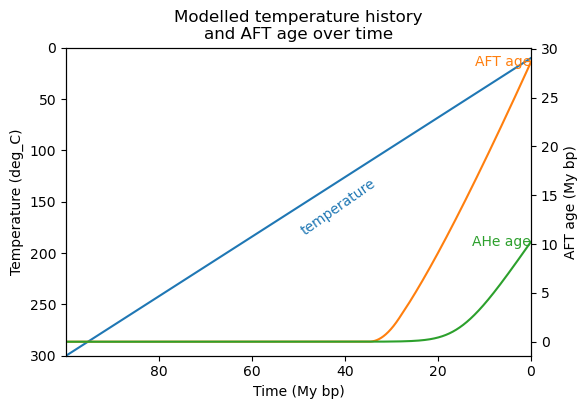

In [23]:
age_evolution_AFT = model_results_AFT["modelled_thermochron_ages"]
age_evolution_AHe = model_results_AHe["modelled_thermochron_ages"]

fig, ax = pl.subplots(1, 1, figsize=(6, 4))

x, y = tT["time"].value / 1e6, tT["temperature"].value
xm = x[int(len(x) / 2)]
ym = y[int(len(y) / 2)]
ax.plot(x, y, color=colors[0], label="T history")
ax.text(xm, ym, "temperature", color=colors[0], va="center", rotation=35)

axr = ax.twinx()

time = tT["time"]
x = time[1:].value / 1e6
y = age_evolution_AFT.value / 1e6
xm = x[int(len(x) / 2)]
ym = y[int(len(y) / 2)]
axr.plot(x, y, color=colors[1])
axr.text(x[-2], y[-2], "AFT age", color=colors[1], va="center", ha="right")

y = age_evolution_AHe.value / 1e6
ym = y[int(len(y) / 2)]
axr.plot(x, y[1:], color=colors[2])
axr.text(x[-2], y[-2], "AHe age", color=colors[2], va="center", ha="right")

ax.set_xlabel("Time (My bp)")
ax.set_ylabel(f"Temperature ({Tu})")
axr.set_ylabel("AFT age (My bp)")

ax.set_xlim(tT["time"].value.max() / 1e6, 0)
ax.set_ylim(tT["temperature"].value.max(), 0)

ax.set_title("Modelled temperature history\nand AFT age over time")